# Compute the Summer Days Climate Index for several years

Starting from the [**Summer Days workflow**](../Examples/Summer_Days_workflow.ipynb) example for the computation of the the **Summer Days index** for one input NetCDF data set, the index can be computed for several years in parallel by exploiting the **iterative and parallel interfaces** made available by the Ophidia Workflow Management System.

**Summer Days index**: number of days where daily maximum temperature $TX > T$ (T is  a reference temperature, e.g. 25°C)


As first step, let's connect to the Ophidia Server

In [1]:
import sys
from PyOphidia import cube,client
cube.Cube.setclient(read_env=True)

Current cdd is /
Current session is http://127.0.0.1/ophidia/sessions/39507385033833434951631798720394551/experiment
Current cwd is /
The last produced cube is all


As input files, we can use the daily NetCDF files produced by the CMCC-CESM model and related to the tasmax variable for the years 2096-2100. 

In [2]:
import glob
glob.glob('/home/ophidia/notebooks/tasmax_*.nc')

['/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc',
 '/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-20961231.nc',
 '/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20970101-20971231.nc',
 '/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20980101-20981231.nc',
 '/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20990101-20991231.nc',
 '/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_21000101-21001231.nc']

The overall workflow structure is the following:
    
<img src="../imgs/Summer_Days_over_several_year.svg" alt="Summer_Days_over_several_year">

To exploit the iterative and parallel interfaces we just need to use the **For Statement**, i.e. the pair of operators **OPH_FOR** (with the *parallel* option enabled) and **OPH_ENDFOR**.

Let's try to build the workflow step-by-step:

We  need to define the global workflow information followed by the various task. Try to complete the various tasks by filling in the missing arguments identified by ```.....```

1. **Create container**
 - We use the *oph_createcontainer* (see http://ophidia.cmcc.it/documentation/users/operators/OPH_CREATECONTAINER.html) to create an empty container in order to organize all the datacubes imported and produced during the workflow execution


In [3]:
summer_days = """{
        "name": "Summer Days over several year",
        "author": "CMCC",
        "abstract": "Summer Days index over several years",
        "exec_mode": "sync",
        "ncores": "1",
        "cwd": "/",
        "tasks":
        [
                {
                        "name": "Create container",
                        "operator": "oph_createcontainer",
                        "on_error": "skip",
                        "arguments": 
                        [
                                "container=summer_days",
                                "dim=lat|lon|time",
                                "dim_type=double|double|double",
                                "hierarchy=oph_base|oph_base|oph_time"
                        ]
                },
"""

The **IMPORT**, **MASK**, **COUNT** and **EXPORT** tasks have to be executed for each of the input years.
So, we use the **OPH_FOR** operator to configure the iterative block and, in particular, to set the number N of loops to be executed. 

2. **Start loop**
 - the **values** argument is an ordered list of N labels (pipe-separated years) to be assigned to cycles (i.e., the years from 2096 to 2100) 
 - the **parallel** option is enabled (```yes```)
 - each label value can be read in the inner tasks by using ```@{year}``` as indicated in the **key** argument
 - a flow dependency from the previous task is required

Each inner task depends on OPH_FOR in order to exploit the value of the label associated with the current iteration. 

In [4]:
summer_days += """
                {
                        "name": "Start loop",
                        "operator": "oph_for",
                        "arguments": 
                        [
                                "key=year",
                                "values=2096|2097|2098|2099|2100",
                                "parallel=yes"
                        ],
                        "dependencies": [
                                { "task": "Create container"}
                        ]
                },
"""

3. **Import**
 - the *src_path* and the *description* parameters in the *oph_importnc* operator are defined in a parametrized way to get the current value of the *year* key for each iteration
 - the task has a flow dependency from the OPH_FOR task
 
 

In [5]:
summer_days += """
                {
                        "name": "Import",
                        "operator": "oph_importnc",
                        "arguments":
                        [
                                "src_path=/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_@{year}0101-@{year}1231.nc",                            
                                "measure=$1",
                                "container=summer_days",
                                "import_metadata=yes",
                                "imp_dim=time",
                                "imp_concept_level=d",
                                "vocabulary=CF",
                                "hierarchy=oph_base|oph_base|oph_time",
                                "description=Max Temp @{year}"
                        ],
                        "dependencies": [
                                { "task": "Start loop"}
                        ]
                },  
"""

4. **Summer Days mask**
 - the *oph_apply* operator (jointly with the *oph_predicate* primitive) is used to identify the summer days: $\{day \mid TX(day) > 298.15\}$ 
 - the task has a **single** dependency from the *Import* task

In [6]:
summer_days += """
                {
                        "name": "Summer Days mask",
                        "operator": "oph_apply",
                        "arguments":
                        [
                                "measure_type=auto",
                                "query=oph_predicate(measure,'x-298.15','>0','1','0')",
                                "description=Summer days mask @{year}"
                        ],
                        "dependencies": [
                                { "task": "Import", "type": "single" }
                        ]
                },
"""

5. **Count summer days**
 - count days below the given threshold on yearly basis by using the *oph_reduce2* operator
 - **single** dependency from *Summer Days mask*

In [7]:
summer_days += """
                {
                        "name": "Count summer days",
                        "operator": "oph_reduce2",
                        "arguments":
                        [
                                "operation=sum",
                                "dim=time",
                                "concept_level=y",
                                "description=Summer Days Count @{year}"
                        ],
                        "dependencies": [
                                { "task": "Summer Days mask", "type": "single" }
                        ]
                },
"""

6. **Export**
 - each Summer Days index is exported to a NetCDF file by using the *oph_exportnc2* operator 
 - **single** dependency from *Count summer days*

In [8]:
summer_days += """
                {
                        "name": "Export",
                        "operator": "oph_exportnc2",
                        "arguments": [
                            "output_name=summer_days_@{year}",
                            "output_path=/home/ophidia/notebooks/"
                        ],
                        "dependencies": [
                            { "task": "Count summer days", "type": "single"}
                        ]
                },
"""

The iterative block ends by means of the **OPH_ENDFOR** operator.

7. **End loop**
 - *oph_endfor* operator
 - flow dependency from **Export** task

In [9]:
summer_days += """
                {
                        "name": "End loop",
                        "operator": "oph_endfor",
                        "arguments": [],
                        "dependencies": [
                                { "task": "Export"}
                        ]
                }
        ]
}
"""

Submit the workflow

In [10]:
cube.Cube.client.wsubmit(summer_days,"tasmax")

Workflow Status
---------------
OPH_STATUS_COMPLETED


Workflow Progress
-----------------
+===========================+=========================+=======================+
| NUMBER OF COMPLETED TASKS | NUMBER OF SKIPPED TASKS | TOTAL NUMBER OF TASKS |
|                           |                         |                       |
+===========================+=========================+=======================+
| 23                        | 0                       | 23                    |
+===========================+=========================+=======================+
Workflow Task List
------------------
+=================================================================================+=============================+=====+===+==========+===============+===+==============+
| OPH JOB ID                                                                      | SESSION CODE                | WOR | M | PARENT M | TASK NAME     | T | EXIT STATUS  |
|                                                  

|                                                                                 |                             |     |   |          |               | P |              |
|---------------------------------------------------------------------------------|-----------------------------|-----|---|----------|---------------|---|--------------|
| http://127.0.0.1/ophidia/sessions/39507385033833434951631798720394551/experimen | 395073850338334349516317987 | 33  | 1 | 168      | Export (4)    | S | OPH_STATUS_C |
| t?33#187                                                                        | 20394551                    |     | 8 |          |               | I | OMPLETED     |
|                                                                                 |                             |     | 7 |          |               | M |              |
|                                                                                 |                             |     |   |          |               |

Run the following command. You should see a netCDF file for each year:
- summer_days_2096.nc
- summer_days_2097.nc
- summer_days_2098.nc
- summer_days_2099.nc
- summer_days_2100.nc

In [11]:
import glob
glob.glob('/home/ophidia/notebooks/summer_*.nc')

['/home/ophidia/notebooks/summer_days_2096.nc',
 '/home/ophidia/notebooks/summer_days_2099.nc',
 '/home/ophidia/notebooks/summer_days_2097.nc',
 '/home/ophidia/notebooks/summer_days_2098.nc',
 '/home/ophidia/notebooks/summer_days_2100.nc']

List the datacubes produced

In [12]:
cube.Cube.list(level=2)

Ophidia Filesystem: /
---------------------
+===+========================================================+================================+========================+
| T | PATH                                                   | DATACUBE PID                   | DESCRIPTION            |
|   |                                                        |                                |                        |
+===+========================================================+================================+========================+
| c | tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc | http://127.0.0.1/ophidia/9/58  | Max Temp imported      |
|---|--------------------------------------------------------|--------------------------------|------------------------|
| c | tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc | http://127.0.0.1/ophidia/9/59  | Max Temp subsetted     |
|---|--------------------------------------------------------|--------------------------------|--------------

Let's plot a map for each year by considering the PIDs associated to the **Summer Days Count @{year}** datacubes. Starting from the output of the previous command, we can define an array of PIDs (sorted by year) and use it in the code below.

In [14]:
pids = ["http://127.0.0.1/ophidia/10/70","http://127.0.0.1/ophidia/10/71",
       "http://127.0.0.1/ophidia/10/72","http://127.0.0.1/ophidia/10/73",
        "http://127.0.0.1/ophidia/10/74"]

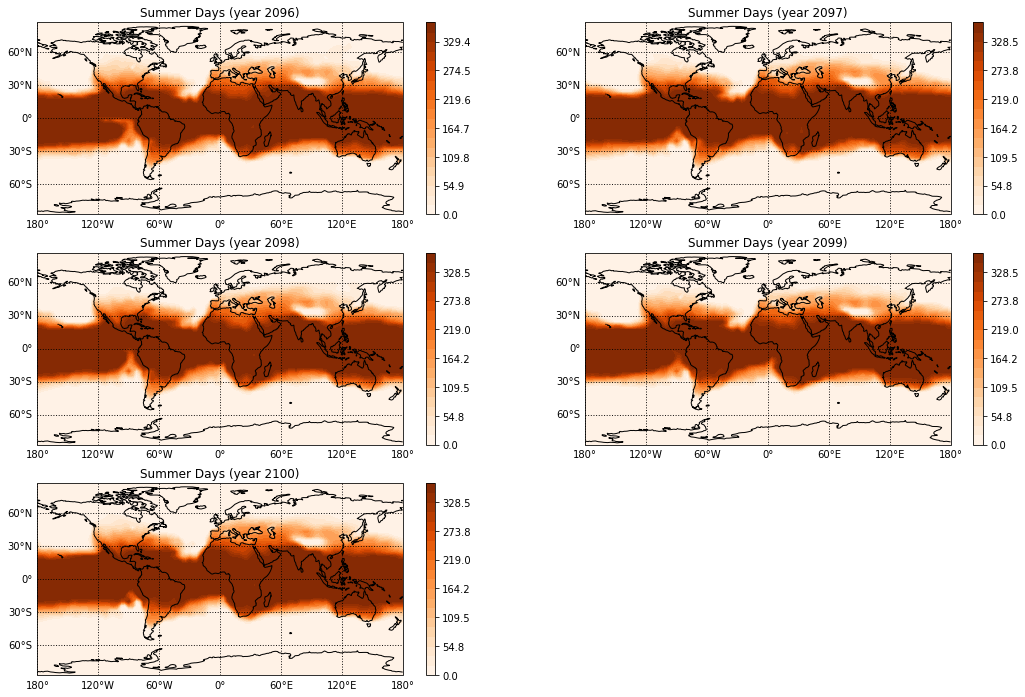

In [15]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")

titles = ["Summer Days (year 2096)","Summer Days (year 2097)","Summer Days (year 2098)","Summer Days (year 2099)","Summer Days (year 2100)"]

#Add Geo axes to the figure with the specified projection (PlateCarree)
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(18, 12), subplot_kw={'projection': projection})
fig.delaxes(axes[2][1])

for v,ax in enumerate(axes.flat):
    
    try:
        datacube = cube.Cube(pid=pids[v])
        data = datacube.export_array(show_time='yes')
        lat = data['dimension'][0]['values'][ : ]
        lon = data['dimension'][1]['values'][ : ]
        var = data['measure'][0]['values'][ : ]
        var = np.reshape(var, (len(lat), len(lon)))
    except:
         continue
            
    #Draw coastline and gridlines
    ax.coastlines()

    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False

    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
    x, y = np.meshgrid(lon_cyclic,lat)

    #Define color levels for color bar
    levStep = (np.nanmax(var)-np.nanmin(var))/20
    clevs = np.arange(np.nanmin(var),np.nanmax(var)+levStep,levStep)

    #Set filled contour plot
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.Oranges)
    ax.set_title(titles[v])
    plt.colorbar(cnplot,ax=ax)

    ax.set_aspect('auto', adjustable=None)

plt.show()

Clear the cube space before running the other workflows

In [16]:
cube.Cube.deletecontainer(container="summer_days",force='yes')

If you are interested in running another example of workflow analysing multiple files, [**Mult-file_example.ipynb**](../Examples/Mult-file_example.ipynb) shows an example (i) computing an index in parallel on multiple files followed (ii) by a statistical analysis on the results from the first part, in a single workflow.

You can now move to the last hands-on notebook [**3-Selection_interface**](3-Selection_interface.ipynb).